# Laboratory 2: Design of Experiments

### Defining the expermients

In this part was neccesary to build a function to generate a Latin Hypercube and the k means cloud point to select the best one an generate the experiments

In [13]:
import matplotlib as mpl
mpl.use("pgf")
pgf_with_pdflatex = {
    "pgf.texsystem": "pdflatex",
    "pgf.preamble": [
         r"\usepackage[utf8x]{inputenc}",
         r"\usepackage[T1]{fontenc}",
         r"\usepackage{cmbright}",
         ]
}
mpl.rcParams.update(pgf_with_pdflatex)
import matplotlib.pyplot as plt

% pylab inline
import numpy as np
import pandas as pd
import pylab as pb
import GPy
import seaborn as sns
pb.ion()


sns.set_context("paper")

##################################################################
##                            part 1                            ##
##################################################################

# generate random uniform numbers
X = np.random.uniform(0,1,(40,4))
#pb.plot(X[:,0],X[:,1],'kx',mew=1.5)

# generate Sobol Low discrepency sequence
XS = SobolSequence(40,4)
#pb.plot(XS[:,0],XS[:,1],'bx',mew=1.5)

def discrepancy(X):
    # compute the discrepency with respect to the center of the domain
    n,d = X.shape
    Xcentred = X-.5
    distCentreX = np.sort(np.max(np.abs(Xcentred),axis=1))
    theoreticalProba = (2*distCentreX)**d
    empiricalProba = 1.*np.arange(n)/n
    D = np.hstack((np.abs(theoreticalProba-empiricalProba,theoreticalProba-empiricalProba+1./n)))
    return(np.max(D))



def maximin(X):
    n,d = X.shape
    distMat = np.sqrt(np.sum((X[:,None,:] - X[None,:,:])**2,axis=2))
    distMat += np.sqrt(d)*np.eye(n)
    return(np.max(np.min(distMat,axis=1)))



def minimax(X):
    n,d = X.shape
    G = SobolSequence(100000,d)
    dXG = np.sum((X[:,None,:]-G[None,:,:])**2,axis=2)
    dXGmin = np.min(dXG,axis=0)
    minimax2 = np.max(dXGmin)
    return(np.sqrt(minimax2))



def IMSE(X,theta=.2):
    n,d = X.shape
    G = SobolSequence(50000,d)
    dX2 = np.sum((X[:,None,:]-X[None,:,:])**2/theta**2,2)
    dG2 = np.sum((G[:,None,:]-X[None,:,:])**2/theta**2,2)
    kX_1 = np.linalg.inv(np.exp(-dX2/2.))
    kG = np.exp(-dG2/2.)
    imse = 1 - np.mean(np.sum(np.dot(kG,kX_1)*kG,axis=1))
    return(imse)

def LHD(n,d):
    ini = np.arange(n)
    data = np.linspace(0, 1, n)
    idx = ini
    for i in range(1,d):
        tmp = np.random.permutation(ini)
        idx = np.vstack((idx, tmp))
    
    hypercube = data[idx[:,0]]
    for i in range(1,n):
        hypercube = np.vstack((hypercube,data[idx[:,i]]))

    return hypercube

def Kmeans(n,d):
    X = np.random.uniform(0,1,(10000,d))
    hypercube,_ = cluster.kmeans(X, n)
    return X, hypercube


Xlhd = LHD(40,4)
_, Xkmeans = Kmeans(40,4)
#pb.plot(X[:,0], X[:,1], 'bx')
#pb.plot(hc[:,0], hc[:,1], 'ro')

print 'DoE Quality Measures: '
print 'Discrepancy random: ', discrepancy(X)
#print 'Discrepancy Sobol: ', discrepancy(XS)
print 'Discrepancy X lhd: ', discrepancy(Xlhd)
print 'Discrepancy X kmeans: ', discrepancy(Xkmeans)
print '-------------------------------------'
print 'Maximin random: ', maximin(X)
#print 'Maximin Sobol: ', maximin(XS)
print 'Maximin X lhd: ', maximin(Xlhd)
print 'MaximinX kmeans: ', maximin(Xkmeans)
print '-------------------------------------'
print 'Minimax random: ', minimax(X)
#print 'Minimax Sobol: ', minimax(XS)
print 'Minimax X lhd: ', minimax(Xlhd)
print 'MinimaxX kmeans: ', minimax(Xkmeans)

Populating the interactive namespace from numpy and matplotlib
DoE Quality Measures: 
Discrepancy random:  0.11605586801
Discrepancy X lhd:  0.185118347518
Discrepancy X kmeans:  0.698228999332
-------------------------------------
Maximin random:  0.540760302278
Maximin X lhd:  0.583579829576
MaximinX kmeans:  0.432735151632
-------------------------------------
Minimax random:  0.683684689841
Minimax X lhd:  0.664957952356
MinimaxX kmeans:  0.472174526512


In [14]:
names = ["Wing-length", "Wing-width", "Tail-length", "Arm-length"]
data = pd.DataFrame(data=Xkmeans, columns=names)
#sns.pairplot(data)

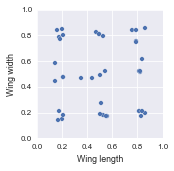

In [15]:
pg = sns.pairplot(data, x_vars=["Wing-length"], y_vars=["Wing-width"])
pg.axes[0,0].set_xlabel('Wing length')
pg.axes[0,0].set_ylabel('Wing width')
plt.savefig('wing_width_vs_wing_length_kmeans.pgf')

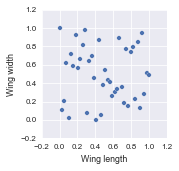

In [16]:
data = pd.DataFrame(data=Xlhd, columns=names)
#sns.pairplot(data)
pg = sns.pairplot(data, x_vars=["Wing-length"], y_vars=["Wing-width"])
pg.axes[0,0].set_xlabel('Wing length')
pg.axes[0,0].set_ylabel('Wing width')
plt.savefig('wing_width_vs_wing_length_lhd.pgf')

## Generating the samples

In [14]:

##################################################################
##                            part 2                            ##
##################################################################

## We assume X is your best DoE over [0,1]^4

## we choose the following parametrization with domain boundaries
namesNew = ['wing angle', 'wing area','total length', 'wing_l / tail_l ratio']
limits = np.array([75,115,20,35,22,31,0.65,1.6]).reshape(4,2).T

# mapping to the new space
def old2new(X):
    Y = 0*X
    Y[:,0] = angle(X)
    Y[:,1] = X[:,0] * X[:,1]  
    Y[:,2] = X[:,0] + X[:,2] + X[:,3] 
    Y[:,3] = X[:,0] / (X[:,2] - 2.5)
    return(Y)

# mapping to the original space
def new2old(Y):
    X = 0*Y
    f_1 = np.sqrt(1+(1/Y[:,3])**2-2*np.cos(Y[:,0]*np.pi/180)*(1/Y[:,3]))
    X[:,0] = (Y[:,2]-5) / (1 + 1./Y[:,3] + f_1)
    X[:,1] = Y[:,1] / X[:,0]
    X[:,2] = X[:,0] / Y[:,3] + 2.5
    X[:,3] = Y[:,2] - X[:,0] - X[:,2]
    return(X)


## Change of coordinate 1: [0,1]^4 to the new domain
X = Xlhd*(limits[1,:]-limits[0,:])[None,:] + limits[0:1,:]

## Change of coordinate 2: new domain to the old one
X = new2old(X)

def single_helico_str(X,expNumber,groupName):
    (Wl, Ww, Tl, Al) = X
    Aw = .7
    Tb = 1.
    Tw = 1.2
    lineHeight = .5

    helico_str = """\\makebox[%fcm]{
    \\begin{pspicture}(%f,%f)(%f,%f)
    \psline[linewidth=0.02](%f,%f)(%f,%f)(%f,%f)(%f,%f)(%f,%f)(%f,%f)(%f,%f)(%f,%f)
    \psline[linewidth=0.02](%f,%f)(%f,%f)(%f,%f)(%f,%f)(%f,%f)(%f,%f)(%f,%f)(%f,%f)
    \psline[linewidth=0.02](%f,%f)(%f,%f)
    \psline[linewidth=0.02, linestyle=dashed, dash=0.17cm 0.10cm](%f,%f)(%f,%f)
    \psline[linewidth=0.02, linestyle=dashed, dash=0.17cm 0.10cm](%f,%f)(%f,%f)
    \psline[linewidth=0.02, linestyle=dashed, dash=0.17cm 0.10cm](%f,%f)(%f,%f)
    \\rput[b](0,%f){\\footnotesize{%s}}
    \\rput[b](0,%f){\\footnotesize{exp %i}}
    \\rput[b](0,%f){\\footnotesize{$W_l = %.2f$}}
    \\rput[b](0,%f){\\footnotesize{$W_w = %.2f$ }}
    \\rput[b](0,%f){\\footnotesize{$T_l = %.2f$}}
    \\rput[b](0,%f){\\footnotesize{$A_l= %.2f$  }}
    \end{pspicture}
    }%%
    """ %(2*Ww,
        Ww,Wl+Al,-Ww,-Tl,
        0,Wl+Al, -Aw,Wl+Al, -Aw,Wl, -Ww,Wl, -Ww,0, -Tw,-Tb, -Tw,-Tl, 0,-Tl,
        0,Wl+Al,  Aw,Wl+Al,  Aw,Wl,  Ww,Wl,  Ww,0,  Tw,-Tb,  Tw,-Tl, 0,-Tl,
        0,Wl+Al,0,0,
        -Aw,Wl,Aw,Wl,
        -Ww,0,Ww,0,
        -Aw,Wl+Al-2.5,Aw,Wl+Al-2.5,
        -Tb-1,groupName,
        -Tb-1-lineHeight,expNumber,
        -Tb-1-2*lineHeight,Wl,
        -Tb-1-3*lineHeight,Ww,
        -Tb-1-4*lineHeight,Tl,
        -Tb-1-5*lineHeight,Al)
    
    return(helico_str)


def writeLaTeX(X,groupName):
    # inputs:   X, Design of Experiments, a (n,4) np.array
    #           groupName, a string (escape LaTeX characters such as \ _ etc)
    # output:   write a file 'helicopters.tex'
    f = open('helicopters.tex', 'w')

    f.write( """\documentclass{article}
    \usepackage[usenames,dvipsnames]{pstricks}
    \usepackage[margin=7mm,paperheight=33cm,paperwidth=21.6cm]{geometry}
    \\begin{document} 
    \\raggedbottom 
    """)
    
    wleft = 19.5
    for i in range(X.shape[0]):
        if 2*X[i,1] < wleft:
            f.write(single_helico_str(X[i,:],i+1,groupName))
        else:
            wleft = 19.5
            f.write("\n \n" + single_helico_str(X[i,:],i+1,groupName))
        wleft -= 2*X[i,1]

    f.write('\end{document}')
    f.close()

writeLaTeX(X, 'JG')
#np.savetxt('X.csv', X, delimiter=',')
#np.savetxt('Xlhd.csv', Xlhd, delimiter=',')